# SAiDL 2023, Core ML Bonus Part

## Transformer based architecture in place of a CNN

### Packages -

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time

torch.random.manual_seed(1)
np.random.seed(1)

### HyperParameters -

In [2]:
batch_size = 1
num_epochs = 5
mha_heads = 4

### General Transform -

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Dataset and DataLoader -

In [4]:
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                               download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

output_iter = iter(test_loader)
features, labels = next(output_iter)
print(features, labels)
print(features.size(), labels.size())

100%|██████████| 169001437/169001437 [00:03<00:00, 48966120.55it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
tensor([[[[ 0.5608,  0.5373,  0.5294,  ...,  0.6941,  0.7020,  0.7569],
          [ 0.5451,  0.5294,  0.5294,  ...,  0.8118,  0.8275,  0.8902],
          [ 0.7412,  0.6706,  0.6392,  ...,  0.9059,  0.9137,  0.9608],
          ...,
          [-0.4353, -0.4431, -0.4196,  ...,  0.7255,  0.4353,  0.2157],
          [-0.4353, -0.4039, -0.3412,  ...,  0.7412,  0.4667,  0.1373],
          [-0.3725, -0.3412, -0.3333,  ...,  0.7020,  0.6235,  0.3804]],

         [[ 0.6863,  0.6549,  0.6471,  ...,  0.8118,  0.8118,  0.8353],
          [ 0.6471,  0.6314,  0.6471,  ...,  0.9059,  0.9059,  0.9216],
          [ 0.7725,  0.7255,  0.7176,  ...,  0.9608,  0.9529,  0.9608],
          ...,
          [-0.4275, -0.4196, -0.3882,  ...,  0.6314,  0.3176,  0.1059],
          [-0.4118, -0.3647, -0.3020,  ...,  0.6627,  0.3647,  0.0353],
          [-0.3333, -0.2941, -0.2784,  ...,  0.6235,  0.5216,  0.2863]],

         [[ 

### Example image -

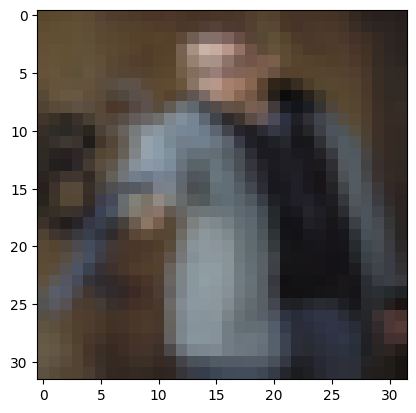

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

### Encoder -

In [6]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=8, in_channels=3, embed_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size//patch_size)**2
        #print(self.n_patches)
        
        self.proj = nn.Conv2d(in_channels, 
                              embed_dim, 
                              kernel_size=patch_size, 
                              stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        self.pos_embedding = nn.Parameter(torch.randn(self.n_patches+1, embed_dim))
        
    def forward(self, x):
        
        x = self.proj(x) #(batch_size, embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2) #(batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2) #(batch_size, n_patches, embed_dim)
        x = torch.cat([self.cls_token, x], dim=1)
        x += self.pos_embedding
        
        return x


class MLPBlock(nn.Sequential):
    def __init__(self, emb_size, expansion=4, drop_p= 0.1):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.ReLU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

        
class EncoderBlock(nn.Module):
    def __init__(self, emb_size=512, MLP_drop_p=0.1, drop_p=0.1, num_heads=4, forward_expansion=4):
        super().__init__()
        
        self.layer1 = nn.LayerNorm(emb_size)
        self.mha = nn.MultiheadAttention(embed_dim=emb_size, num_heads=num_heads, dropout=drop_p, batch_first=True)
        self.layer2 = nn.LayerNorm(emb_size)
        self.mlp = MLPBlock(emb_size, expansion=forward_expansion, drop_p=MLP_drop_p)
        self.dropout = nn.Dropout(drop_p)
    
    def forward(self, x):
        
        res = x
        x, _ = self.mha(self.layer1(x), self.layer1(x), self.layer1(x))
        x += res
        res = x
        x = self.layer2(x)
        x = self.mlp(x)
        x = self.dropout(x)
        x += res
        
        return x

### Overall Model -

In [7]:
class VisionTransformer(nn.Module):
    def __init__(self, depth, n_classes=100):
        super().__init__()
        
        self.depth = depth
        self.embedder = PatchEmbed()
        self.encoders = nn.ModuleList([])
        for _ in range(depth):
            self.encoders.append(EncoderBlock())
        self.out = nn.Sequential(nn.LayerNorm(512), nn.Linear(512, n_classes))
    
    def forward(self, x):
        
        x = self.embedder(x)
        for module in self.encoders:
            x = module(x)
        x = torch.sum(x, axis=1)
        x = self.out(x)
        
        return x

In [9]:
print(VisionTransformer(2))

VisionTransformer(
  (embedder): PatchEmbed(
    (proj): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
  )
  (encoders): ModuleList(
    (0-1): 2 x EncoderBlock(
      (layer1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (layer2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLPBlock(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (out): Sequential(
    (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=512, out_features=100, bias=True)
  )
)


### Loss -

In [10]:
def gumbel_sample(shape, eps = 1e-8):
    
    U = torch.rand(shape)
    #U = U.to(device)
    return -torch.log(-torch.log(U + eps) + eps)

class loss_gumbel(nn.Module):
    
    def __init__(self):
        super(loss_gumbel, self).__init__()
    
    def forward(self, output, target, temp):
        
        criterion = nn.CrossEntropyLoss()
        y_hat = output + gumbel_sample(output.size())
        loss = criterion(y_hat/temp, target)
        
        return loss

### Training -

In [11]:
ViT = VisionTransformer(1)
criterion = loss_gumbel()
optimizer = optim.SGD(ViT.parameters(), lr=1e-3)

In [13]:
loss_hist = []
iter_no = []
n_total_steps = len(train_loader)
times = []
current = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [1, 3, 32, 32] = 1, 3, 1024

        # Forward pass
        outputs = ViT(images)
        loss = criterion(outputs, labels, 0.9)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % (n_total_steps/5) == 0:
            loss_hist.append(loss.item())
            iter_no.append(i + epoch*n_total_steps)
        
        #if i < 10:
        #    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

        if (i + 1) % (n_total_steps/10) == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    
    times.append(time.time() - current)
    current = time.time()
        
avg_time = sum(times)/len(times)

print('Finished Training')

Epoch [1/5], Step [5000/50000], Loss: 3.2109
Epoch [1/5], Step [10000/50000], Loss: 4.8284
Epoch [1/5], Step [15000/50000], Loss: 4.4468
Epoch [1/5], Step [20000/50000], Loss: 5.8988
Epoch [1/5], Step [25000/50000], Loss: 2.7370
Epoch [1/5], Step [30000/50000], Loss: 6.3933
Epoch [1/5], Step [35000/50000], Loss: 6.5404
Epoch [1/5], Step [40000/50000], Loss: 6.2231
Epoch [1/5], Step [45000/50000], Loss: 2.1524
Epoch [1/5], Step [50000/50000], Loss: 5.4130
Epoch [2/5], Step [5000/50000], Loss: 5.1012
Epoch [2/5], Step [10000/50000], Loss: 7.6824
Epoch [2/5], Step [15000/50000], Loss: 4.5441
Epoch [2/5], Step [20000/50000], Loss: 7.8161
Epoch [2/5], Step [25000/50000], Loss: 1.4554
Epoch [2/5], Step [30000/50000], Loss: 1.4788
Epoch [2/5], Step [35000/50000], Loss: 4.5234
Epoch [2/5], Step [40000/50000], Loss: 2.6506
Epoch [2/5], Step [45000/50000], Loss: 3.1817
Epoch [2/5], Step [50000/50000], Loss: 7.3675
Epoch [3/5], Step [5000/50000], Loss: 2.1263
Epoch [3/5], Step [10000/50000], Loss

### Model Evaluation -

Text(0.5, 1.0, 'iterations vs loss')

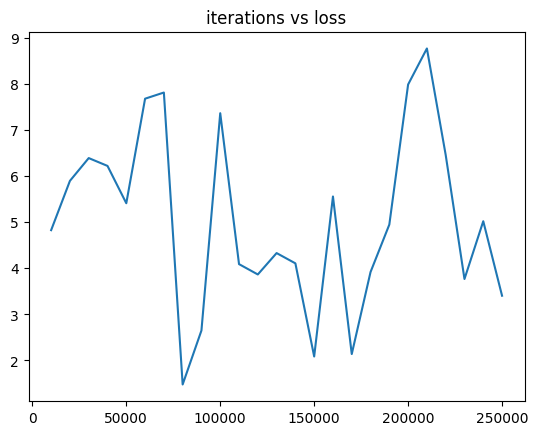

In [14]:
plt.plot(iter_no, loss_hist)
plt.title("iterations vs loss")

In [19]:
avg_time = sum(times)/len(times)
print(f"With gumbel softmax, each epoch lasted {avg_time}s")

With gumbel softmax, each epoch lasted 632.0854979991913s


Accuracy of the network: 21.46 %


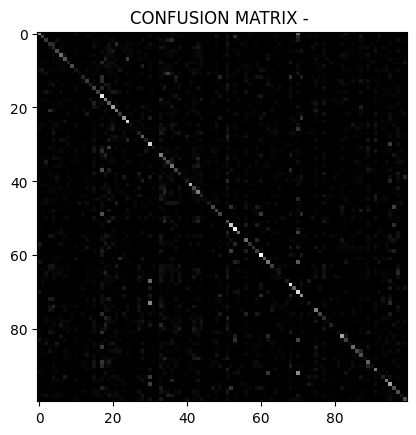

[[42.  1.  0. ...  0.  0.  0.]
 [ 2. 19.  0. ...  0.  1.  0.]
 [ 1.  0. 16. ...  3.  1.  2.]
 ...
 [ 0.  0.  0. ... 22.  0.  0.]
 [ 1.  2.  4. ...  1.  7.  1.]
 [ 0.  0.  0. ...  1.  0. 22.]]
max precision at class - 9 = 65.625%


In [20]:
with torch.no_grad():
    confusion_matrix = np.zeros((100, 100))
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        outputs = ViT(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        for i in range(batch_size):
            confusion_matrix[labels[i]][predicted[i]] += 1
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    
    plt.imshow(confusion_matrix, cmap = 'gray')
    plt.title('CONFUSION MATRIX - ')
    plt.show()
    
    print(confusion_matrix)
    
    precision = np.zeros((100,))
    recall = np.zeros((100,))
    
    for classes in range(100):
        if(np.sum(confusion_matrix[:,classes]) > 0):
            precision[classes] = confusion_matrix[classes][classes]/np.sum(confusion_matrix[:,classes])
        else:
            precision[classes] = 0
        if(np.sum(confusion_matrix[classes,:]) > 0):    
            recall[classes] = confusion_matrix[classes][classes]/np.sum(confusion_matrix[classes,:])
        else:
            recall[classes] = 0
    
    max_p = precision[np.argmax(precision)]
    
    print(f'max precision at class - {np.argmax(precision)} = {max_p*100}%')

In [22]:
precision = 0
recall = 0
for classes in range(100):
    if(np.sum(confusion_matrix[:,classes]) > 0):
        precision += confusion_matrix[classes][classes]/np.sum(confusion_matrix[:,classes])
    if(np.sum(confusion_matrix[classes,:]) > 0):    
        recall += confusion_matrix[classes][classes]/np.sum(confusion_matrix[classes,:])
        
precision /= 100
recall /= 100

F1 = 2/((1/precision) + (1/recall))

In [23]:
print(f"Precision - {precision:.4f}, Recall - {recall:.4f} and F1-score is - {F1:.4f}")

Precision - 0.2180, Recall - 0.2146 and F1-score is - 0.2163


# Thanks!